In [2]:
#| default_exp diffusion_laziness
# Diffusion Curvature utils
from diffusion_curvature.utils import *
from diffusion_curvature.datasets import *
# Python necessities
import numpy as np
import jax
import jax.numpy as jnp
from fastcore.all import *
import matplotlib.pyplot as plt
# Notebook Helpers
from nbdev.showdoc import *
from tqdm.notebook import trange, tqdm
from fastcore.all import *
%load_ext autoreload
%autoreload 2

# Diffusion Laziness Estimators
> What's the shape of this diffusion?

# Wasserstein Spread of Diffusion

In [3]:
#|export
import jax
import jax.numpy as jnp
from jax import jit
import scipy

@jit
def wasserstein_spread_of_diffusion(
                D:jax.Array, # manifold geodesic distances
                Pt:jax.Array, # powered diffusion matrix/t-step ehat diffusions
                ):
        """
        Returns how "spread out" each diffusion is, with wasserstein distance
        Presumes that the manifold distances have been separately calculated
        """
        return jnp.sum(D * Pt, axis=-1)

### Benchmarking

In [4]:
D = np.random.rand(1000,1000)
Pt = np.random.rand(1000,1000)
Pt = Pt / np.sum(Pt, axis=1)[:,None]

In [5]:
%%timeit
wasserstein_spread_of_diffusion(D,Pt)

1.85 ms ± 22.6 μs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [6]:
key = jax.random.PRNGKey(0)
Djax = jax.random.normal(key, (1000, 1000))
key = jax.random.PRNGKey(10)
Ptjax = jax.random.normal(key, (1000, 1000))

In [7]:
%%timeit
wasserstein_spread_of_diffusion(Djax,Ptjax)

449 μs ± 15 μs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


Wow, it's nearly two orders of magnitude faster when using jax arrays.

# Entropy of Diffusion

In [8]:
#|export
import jax.scipy
import jax.numpy as jnp

def entropy_of_diffusion(
    Pt:jax.Array, # powered diffusion matrix
    epsilon=1e-5, # threshold for small values, for speed
): 
        """
        Returns the pointwise entropy of diffusion from the powered diffusion matrix in the input
        Assumes that Pt sums to 1
        """
        # Use only the elements of Pt that are greater than epsilon
        Pt = Pt * (Pt>epsilon)
        # Normalize Pt so that it sums to 1
        Pt = Pt / (jnp.sum(Pt, axis=-1) + 1e-12)
        # Pt = (Pt + 1e-10) /(1 + 1e-10*Pt.shape[0]) # ensure, for differentiability, that there are no zeros in Pt, but that it still sums to 1.
        entropy_elementwise = jax.scipy.special.entr(Pt)
        entropy_of_rows = jnp.sum(entropy_elementwise, axis=-1)
        # normalize so max value is 1
        # entropy_of_rows = entropy_of_rows / (-jnp.log(1/jnp.sum(Pt>epsilon, axis=-1)))
        return entropy_of_rows

In [9]:
from scipy.stats import entropy

In [10]:
assert jnp.allclose(entropy_of_diffusion(Pt),entropy(Pt,axis=1), atol = 1e-3)

# Diffusion Laziness Model

The above functions estimate the laziness of a powered diffusion matrix, at a single time. Here, we extend the computation over multiple times, as well as making it more convenient to call.

In [11]:
from diffusion_curvature.heat_diffusion import *

In [12]:
Pts = powers_of_diffusion(Pt, list(range(1,40)))

## Divergences and Distances

In [13]:
# test data
from diffusion_curvature.datasets import sphere
from diffusion_curvature.kernels import *
import scipy

In [14]:
#|export
@jax.jit
def kl_div(A, B, eps = 1e-12):
    # Calculate Kullback-Leibler divergence
    # get rid of zero values
    A = jnp.where(A == 0, eps, A)
    B = jnp.where(B == 0, eps, B)
    v = A*(jnp.log(A) - jnp.log(B)) 
    return jnp.sum(v)

In [15]:
test_eq(
    kl_div(Pts[0][1], Pts[10][1]).item(), 
    scipy.special.kl_div(Pts[0][1], Pts[10][1]).sum()
)

AssertionError: ==:
0.19046354293823242
0.19046352348850176

In [16]:
#|export
@jax.jit
def js_dist(
    P:jax.Array, 
    Q:jax.Array,
):
    """Compute the Jensen-Shannon distance between two probability distributions.

    Input
    -----
    P, Q : array-like
        Probability distributions of equal length that sum to 1
    """

    M = 0.5 * (P + Q)

    # Get the JS DIVERGENCE
    result = 0.5 * (kl_div(P, M) + kl_div(Q, M))
    # Take sqrt to get the JS DISTANCE
    return jnp.sqrt(jnp.abs(result))

In [17]:
assert jnp.allclose(
    js_dist(Pts[0][1], Pts[10][1]).item(), 
    scipy.spatial.distance.jensenshannon(Pts[0][1], Pts[10][1]).sum()
)

One can vectorize these functions with jax.vmap

In [18]:
js_dist_vectorized = jax.vmap(js_dist, (0, 0), 0)

In [19]:
vect_output = js_dist_vectorized( Pts[3], Pts[20])
for i, v in enumerate(vect_output):
    test_eq(v, js_dist(Pts[3][i], Pts[20][i]))

## Integrating laziness over time

In [20]:
ts = np.arange(1,50)
Pts = powers_of_diffusion(Pt, ts)

We must convert times to distances along the diffusion trajectory.

In [21]:
#|export
from scipy.spatial.distance import jensenshannon
def diffusion_distances_along_trajectory(diffusions):
    # given a sequence of diffusions, returns the distances between each 
    js_dist_vectorized = jax.vmap(js_dist, (0, 0), 0)
    distances = [jnp.zeros(diffusions[0].shape[0])]
    for idx in range(len(diffusions)-1):
        step_distance = js_dist_vectorized(diffusions[idx+1], diffusions[idx])
        distances.append(
            distances[-1] + step_distance
        )
    return jnp.stack(distances)

In [22]:
ds = diffusion_distances_along_trajectory(Pts)

In [23]:
ds.shape

(49, 1000)

We'll use a trapezoidal style integral.

In [24]:
#|export
import jax
import jax.numpy as jnp

@jax.jit
def trapezoidal_rule(x, y):
    # Ensure x and y are JAX arrays
    x = jnp.asarray(x)
    y = jnp.asarray(y)
    
    # Calculate the differences between consecutive x values along the second axis (axis=1)
    dx = x[:, 1:] - x[:, :-1]
    
    # Calculate the trapezoidal areas along the second axis, handling NaNs
    trapezoidal_areas = dx * (y[:, :-1] + y[:, 1:]) / 2
    
    # Mask out the NaNs in the trapezoidal areas
    valid_mask = ~jnp.isnan(trapezoidal_areas)
    trapezoidal_areas = jnp.where(valid_mask, trapezoidal_areas, 0.0)
    
    # Sum up the areas along the second axis to get the integral for each row
    integral = jnp.sum(trapezoidal_areas, axis=1)
    
    return integral

## Diffusion Laziness Wrapper

In [25]:
#|export
from typing import Literal
from diffusion_curvature.kernels import diffusion_matrix_from_affinities
from diffusion_curvature.heat_diffusion import heat_diffusion_from_dirac, powers_of_diffusion
from copy import deepcopy

class DiffusionLaziness():
    DIFFUSION_TYPES = Literal['diffusion matrix','heat kernel']
    LAZINESS_METHODS = Literal['Entropic', 'Wasserstein']
    def __init__(
        self,
        diffusion_type:DIFFUSION_TYPES = "diffusion matrix",
        laziness_method:LAZINESS_METHODS = "Entropic",
        smoothing = 2, 
    ):
        store_attr()

    def fit_transform(
        self,
        G, # graph
        ts, # time or list of times.
        idx = None, # supply an integer or list of indices, and we'll only calculate their laziness
        D = None,
        t_dist:int = 25, # diffusion time for distance calculation
    ):
        # get jax affinity matrix, and compute diffusion matrix from graph
        W = G.W
        if scipy.sparse.issparse(W):
            W = W.todense()
        ts = deepcopy(ts)
        if isinstance(ts, int): ts = [ts]
        if D is None: ts += [t_dist]
        if self.smoothing: ts = [self.smoothing] + ts
        W = jnp.array(W)
        # get powers of diffusion
        match self.diffusion_type:
            case 'diffusion matrix':
                P = diffusion_matrix_from_affinities(W)
                Pts = powers_of_diffusion(P, ts)
            case 'heat kernel':
                raise NotImplementedError # TODO: Implement and test
                Pts = heat_diffusion_from_dirac(G, ts)
        match self.laziness_method:
            case "Wasserstein":
                if D is None: D = phate_distances(Pts[-1])
                laziness_with_distance = partial(wasserstein_spread_of_diffusion, D = D)
                laziness_fn = jax.vmap(wasserstein_spread_of_diffusion)
            case "Entropic":
                laziness_fn = jax.vmap(entropy_of_diffusion, (0), 0)
        self.ts = ts
        diffusions = Pts

        if D is None: 
            diffusions = diffusions[:-1] # the last Pt is for heat 
            self.ts = self.ts[:-1]
        if self.smoothing is not None:
            self.smoothing_P = diffusions[0]
            diffusions = diffusions[1:]
            self.ts = self.ts[1:]


        if idx is not None: diffusions = [d[idx][None,:] for d in diffusions]

        self.ls = laziness_fn(jnp.stack(diffusions)).T 
        self.ds = diffusion_distances_along_trajectory(diffusions).T
        if len(self.ts) > 1: laziness_under_curve = trapezoidal_rule(self.ds, self.ls)
        else:                laziness_under_curve = self.ls

        if self.smoothing and idx is None: # TODO there are probably more intelligent ways to do this smoothing
            # Local averaging to counter the effects local density
            average_laziness = self.smoothing_P @ laziness_under_curve
            laziness_under_curve = average_laziness.squeeze()
        return laziness_under_curve
    
    def integrate_laziness_with_bounds(self, min_d, max_d, idxs=None):
        if idxs is None:
            idxs = jnp.arange(self.ds.shape[0])
        else:
            idxs = jnp.asarray(idxs)
        
        ds_filtered = self.ds[idxs]
        ls_filtered = self.ls[idxs]
        
        mask = (ds_filtered >= min_d) & (ds_filtered <= max_d)
        valid_ds = jnp.where(mask, ds_filtered, jnp.nan)
        valid_ls = jnp.where(mask, ls_filtered, jnp.nan)
        
        results = trapezoidal_rule(valid_ds, valid_ls)

        return results
        

We'll test this with our old friend, the torus.

In [26]:
X, ks = torus(2000)
G = get_adaptive_graph(X)

2024-08-07 12:43:49,240:[WARNING](pygsp.graphs.graph.check_weights): The main diagonal of the weight matrix is not 0!


In [27]:
%%timeit
Laziness_torus = DiffusionLaziness()
ks = Laziness_torus.fit_transform(G, ts = list(range(1,40)))

2.01 s ± 31.7 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


<3 seconds to calculate 2000 points' curvature isn't bad, though is an order of magnitude faster than the single-diffusion version.

In [28]:
Laziness_torus = DiffusionLaziness()
ks = Laziness_torus.fit_transform(G, ts = list(range(1,40)))

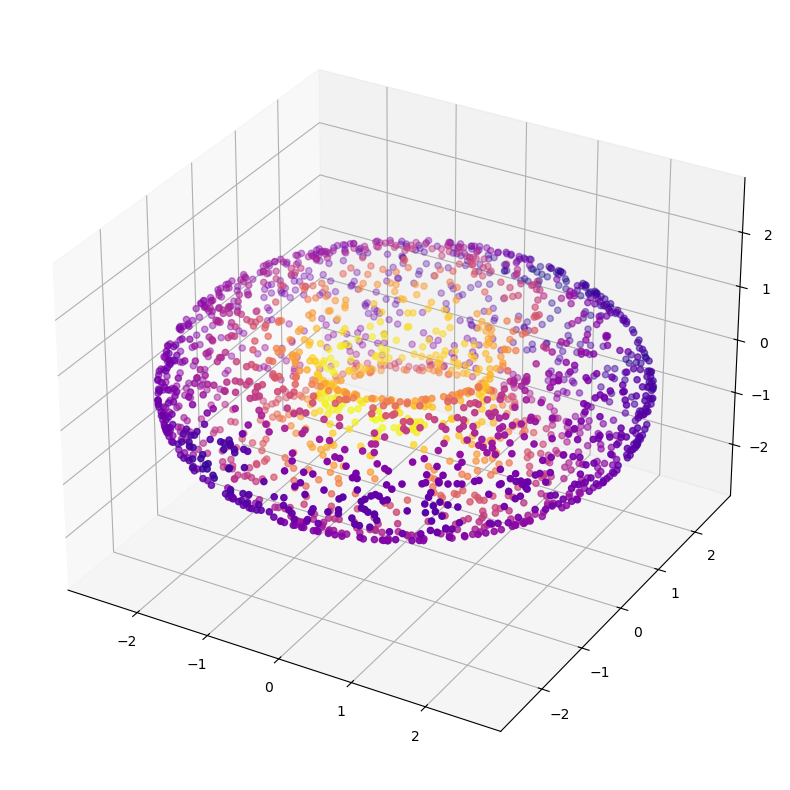

In [29]:
plot_3d(X, ks)

And the sphere, for comparison

In [30]:
X_sphere, ks = sphere(2000)
G_sphere = get_adaptive_graph(X_sphere)

2024-08-07 12:44:09,553:[WARNING](pygsp.graphs.graph.check_weights): The main diagonal of the weight matrix is not 0!


In [31]:
Laziness_sphere = DiffusionLaziness()
ks_sphere = Laziness_sphere.fit_transform(G_sphere, ts = list(range(1,40)))

In [32]:
Laziness_sphere.ls.shape

(2000, 39)

In [33]:
Laziness_sphere.ds.shape

(2000, 39)

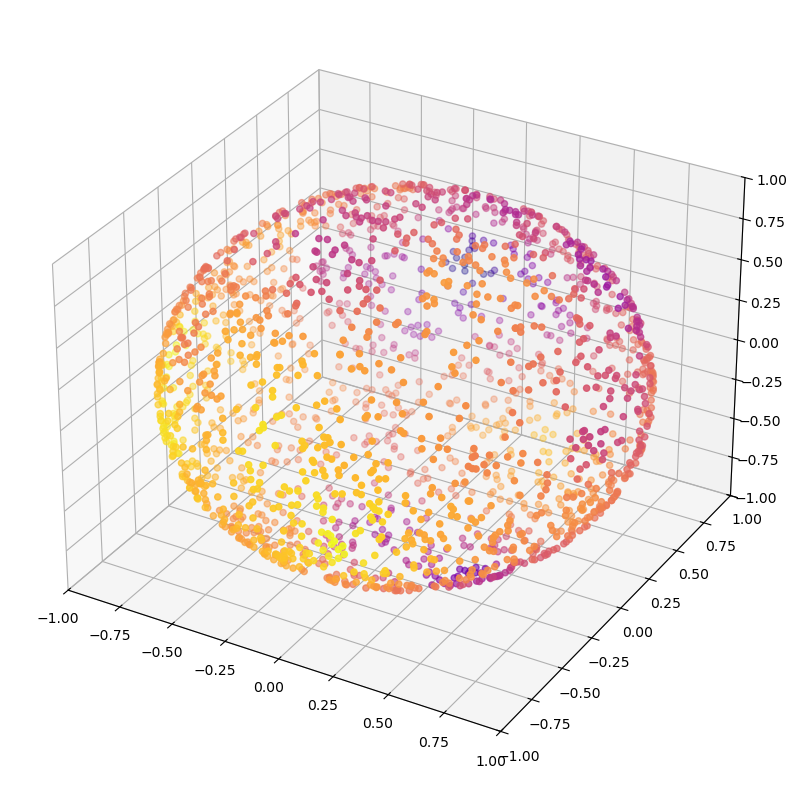

In [34]:
plot_3d(X_sphere, ks_sphere)

Single idx testing:

In [35]:
Laziness_single_idx = DiffusionLaziness()
k = Laziness_single_idx.fit_transform(G, list(range(1,40)), idx = 1)

In [36]:
k

Array([6.25486], dtype=float32)

In [37]:
Laziness_single_idx = DiffusionLaziness()
k = Laziness_single_idx.fit_transform(G, list(range(1,40)), idx = 0)

In [38]:
k

Array([5.7980785], dtype=float32)

It is surprisingly quicker with a single index, even though it currently still computes all of the matrix powers. What's the slowest part?

In [39]:
%%timeit
Laziness_single_idx = DiffusionLaziness()
k = Laziness_single_idx.fit_transform(G, list(range(1,40)), idx = 0)

1.22 s ± 77.1 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


Does it work with a single time?

In [40]:
Laziness_single_idx = DiffusionLaziness()
k = Laziness_single_idx.fit_transform(G, [5], idx = 0)
k

Array([[4.810628]], dtype=float32)

In [41]:
above_min = (Laziness_sphere.ds[0] >= 0).astype(int)
above_max = (Laziness_sphere.ds[0] <= 1.2).astype(int)
valid_idxs = jnp.nonzero(above_min * above_max)[0]
        

In [42]:
valid_idxs

Array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33],      dtype=int32)

In [ ]:
above_min

Array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32)

In [ ]:
jnp.max(Laziness_sphere.ds)

Array(1.2892594, dtype=float32)

Integration with bounds:

In [ ]:
Laziness_sphere.integrate_laziness_with_bounds(0, 1)

Array([4.915861 , 4.747193 , 4.604779 , ..., 4.8067784, 4.644313 ,
       4.5258355], dtype=float32)

In [ ]:
Laziness_sphere.integrate_laziness_with_bounds(0, 0.5, idxs = [0,1,2])

Array([2.120566 , 1.8812729, 1.6539733], dtype=float32)

## Visualization Utils

In [43]:
#|export
from functools import partial
import numpy as np
import matplotlib.pyplot as plt
from functools import partial
from fastcore.all import *
from tqdm.auto import tqdm
import inspect

def curvature_curves(*diffusion_curvatures, idx=0, title="Curvature Curves", also_plot_against_time = True, **kwargs):
    if also_plot_against_time: fig, axs = plt.subplots(1, 2, figsize=(12, 6))
    else:                      fig, axs = plt.subplots(1, 1, figsize=(6, 6))
    for dc in diffusion_curvatures:
        dc_name = None
        for frame_record in inspect.stack():
            frame = frame_record.frame
            for name, obj in frame.f_globals.items():
                if obj is dc:
                    dc_name = name
            for name, obj in frame.f_locals.items():
                if obj is dc:
                    dc_name = name
        if dc_name is None:
            dc_name = "Unknown"
        t_values, distances, curvatures = dc.ts, dc.ds[idx], dc.ls[idx]
        # else:
        #     t_values, distances, curvatures = dc.manifold_lazy_est.ts, dc.manifold_lazy_est.ds[idx], dc.manifold_lazy_est.ls[idx]
        axs[1].plot(distances, curvatures, label=dc_name)
        if also_plot_against_time: axs[0].plot(t_values, curvatures, label=dc_name)
        
    axs[1].set_title("Diffusion Energy Vs. Diffusion Trajectory Distance")
    axs[1].set_xlabel('Distance')
    axs[1].set_ylabel('Diffusion Energy')
    if also_plot_against_time:
        axs[0].set_title("Diffusion Energy vs. Time")
        axs[0].set_xlabel('Time ($t$)')    
        axs[0].set_ylabel('Diffusion Energy')
        axs[0].legend()
    fig.suptitle(title)
    axs[1].legend()
    plt.show()

In [44]:
len(Laziness_torus.ls[0])

39

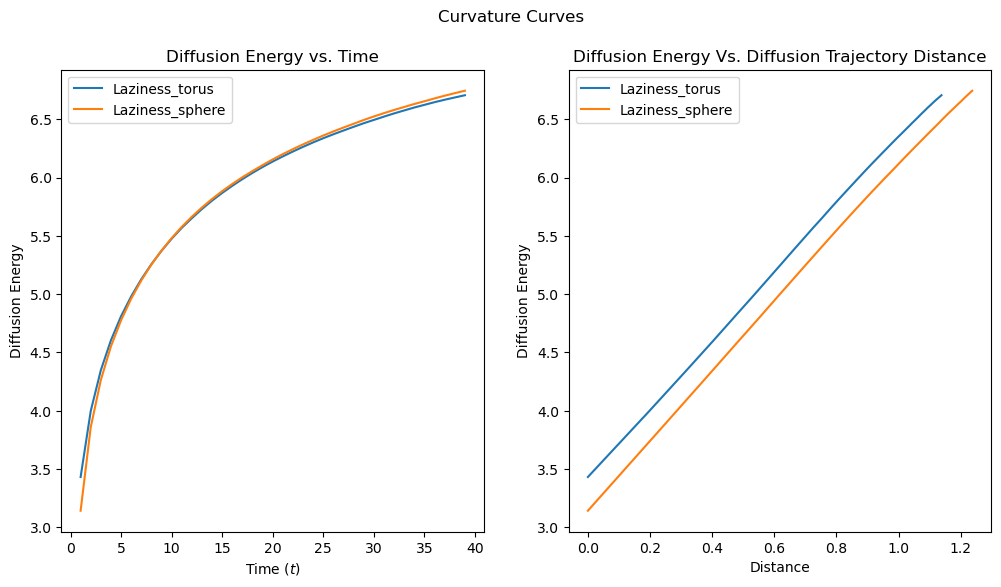

In [45]:
curvature_curves(Laziness_torus, Laziness_sphere, also_plot_against_time = True)

## Multi-set Integrator

A single instance of Laziness will, if asked, return a single scalar representing the area under the laziness curve. This works well for comparing laziness across a single dataset.

However, to compare laziness across multiple datasets -- especially datasets of varying samplings -- we need to take the integrals in the context of another. Specifically, we only wan t the area under the curve up until the minumum maximum distance achieved by any. Where one curve ends, all must end.

This function performs that bit of trickery. It takes in any number of DiffusionLaziness objects, finds the minimum maximum trajectory distance, and returns a list of the integrals of each Laziness instance only until that distance.

This makes most sense for a single given idx. If multiple idxs are supplied, we take the mean distances across the idxs, and take the minimum maximum of these.

In [46]:
#|export
def compare_curvature_across_datasets(
    *diffusion_lazinesses,
    idxs:List  = None # list of idxs to compare. Can also be a list of lists of idxs, one per DiffusionLaziness
):
    if idxs is None:
        idxs = jnp.arange(diffusion_lazinesses[0].ds.shape[0])
    def _get_means_by_idxs(DL, id):
        idxs = jnp.array(id)
        if len(idxs) == 1:
            mean_ds = DL.ds[id[0]] 
        else:
            mean_ds = jnp.mean(DL.ds[id], axis=0)
        return mean_ds

    if isinstance(idxs[0], List) or isinstance(idxs[0], jax.Array):
        assert len(idxs) == len(diffusion_lazinesses)
        mean_ds = [_get_means_by_idxs(diffusion_lazinesses[i],idxs[i]) for i in range(len(diffusion_lazinesses))]
    else:
        mean_ds = [_get_means_by_idxs(DL,idxs) for DL in diffusion_lazinesses]
    
    max_ds = jnp.array([jnp.max(md) for md in mean_ds])
    minmax_ds = jnp.min(max_ds)
    if isinstance(idxs[0], List) or isinstance(idxs[0], jax.Array):
        bounded_integrals = [diffusion_lazinesses[i].integrate_laziness_with_bounds(0, minmax_ds, idxs=idxs[i]) for i in range(len(diffusion_lazinesses))]
    else:
        bounded_integrals = [DL.integrate_laziness_with_bounds(0, minmax_ds, idxs = idxs) for DL in diffusion_lazinesses]

    return bounded_integrals

In [47]:
compare_curvature_across_datasets(Laziness_torus, Laziness_sphere, idxs = [0])

[Array([5.798048], dtype=float32), Array([5.4437346], dtype=float32)]

In [51]:
compare_curvature_across_datasets(Laziness_torus, Laziness_sphere, idxs = [0,5,6,7,8,45])

TypeError: Using a non-tuple sequence for multidimensional indexing is not allowed; use `arr[array(seq)]` instead of `arr[seq]`. See https://github.com/google/jax/issues/4564 for more information.

In [52]:
compare_curvature_across_datasets(Laziness_torus, Laziness_sphere, idxs = None)

AssertionError: 

In [48]:
#|export
def compare_curvature_across_datasets_by_maximum_mean_discrepancy(
    target_laziness:DiffusionLaziness, # the DiffusionLaziness operator of the manifold
    comparison_laziness:DiffusionLaziness,
    idxs:List, # the DiffusionLaziness operator of the comparison space 
    method: str = "quadratic" # method can be "quadratic" or "piecewise"
):
    assert method in ["quadratic", "piecewise"], "method must be 'quadratic' or 'piecewise'"

    from jax.scipy.linalg import lstsq

    def quadratic_regression(x, y):
        # Fit a quadratic polynomial y = ax^2 + bx + c
        A = jnp.vstack([x**2, x, jnp.ones_like(x)]).T
        coeffs, _, _, _ = lstsq(A, y)
        return coeffs

    def evaluate_quadratic(coeffs, x):
        return coeffs[0] * x**2 + coeffs[1] * x + coeffs[2]

    # Extract the ds and ls from each, treating them as x and y coordinates to be modeled
    target_x = target_laziness.ds[idxs] # has shape num_idxs x num_ts
    target_y = target_laziness.ls[idxs] 
    comp_x = comparison_laziness.ds
    comp_y = comparison_laziness.ls

    if method == "quadratic":
        # Perform quadratic regression on these pairs, creating num_idxs functions target_fns, comp_fns
        target_coeffs = jax.vmap(quadratic_regression)(target_x, target_y)
        comp_coeffs = quadratic_regression(comp_x, comp_y)

        # Create a range of x values to evaluate the polynomials
        x_values = jnp.linspace(jnp.min(target_x), jnp.max(target_x), 500)

        # Evaluate the polynomials
        target_fns = jax.vmap(lambda coeffs: evaluate_quadratic(coeffs, x_values))(target_coeffs)
        comp_fn = evaluate_quadratic(comp_coeffs, x_values)
    else:
        # Use piecewise linear approximation
        x_values = jnp.unique(jnp.concatenate([target_x.flatten(), comp_x]))
        target_fns = jax.vmap(lambda x, y: jnp.interp(x_values, x, y))(target_x, target_y)
        comp_fn = jnp.interp(x_values, comp_x, comp_y)

    if method == "quadratic":
        # Find the x value where the mean absolute discrepancy is greatest
        discrepancies = jnp.abs(target_fns - comp_fn)
        mean_discrepancies = jnp.mean(discrepancies, axis=0)
        max_discrepancy_idx = jnp.argmax(mean_discrepancies)
        max_discrepancy_x = x_values[max_discrepancy_idx]

        # Return the associated y values
        return max_discrepancy_x, target_fns[:, max_discrepancy_idx], comp_fn[max_discrepancy_idx]
    else:
        # Find the x value where the mean absolute discrepancy is greatest
        discrepancies = jnp.abs(target_fns - comp_fn)
        mean_discrepancies = jnp.mean(discrepancies, axis=0)
        max_discrepancy_idx = jnp.argmax(mean_discrepancies)
        max_discrepancy_x = x_values[max_discrepancy_idx]

        # Return the associated y values
        return max_discrepancy_x, target_fns[:, max_discrepancy_idx], comp_fn[max_discrepancy_idx]
    
    

In [62]:
#|export
import jax
import jax.numpy as jnp
from typing import List

def compare_curvature_across_datasets_by_locality_fraction(
        target_laziness: DiffusionLaziness, 
        comparison_laziness: DiffusionLaziness,
        idxs: List,
        idxs_comparison:List = None,
        locality_scale: float = None,
): 
    if isinstance(idxs, List): idxs = jnp.array(idxs)
    if isinstance(idxs_comparison,List): idxs_comparison = jnp.array(idxs_comparison)
    if idxs_comparison is None: idxs_comparison = idxs
    ds_dl1 = target_laziness.ds[idxs]
    ds_dl2 = comparison_laziness.ds[idxs_comparison]
    ls_dl1 = target_laziness.ls[idxs]
    ls_dl2 = comparison_laziness.ls[idxs_comparison]
    
    def get_interpolated_laziness(locality_scale, testing=False):
        avg_max_ds = jnp.mean(ds_dl1[:,-1])
        d = avg_max_ds * locality_scale
        if d > jnp.min(ds_dl2[:,-1]): 
            if testing: return 0, 0
            else: raise ValueError("Locality scale produces a distance which exceeds the comparison space size. Please try a smaller locality scale")

        distance_interp_1 = jax.vmap(lambda x, y: jnp.interp(d, x, y))(ds_dl1, ls_dl1)
        distance_interp_2 = jax.vmap(lambda x, y: jnp.interp(d, x, y))(ds_dl2, ls_dl2)
        return distance_interp_1, distance_interp_2
    
    def get_mean_difference(locality_scale):
        d1, d2 = get_interpolated_laziness(locality_scale, testing=True)
        return jnp.mean(jnp.abs(d1 - d2))
    
    if locality_scale is None:
        possible_scales = jnp.linspace(0.01, 1.0, 20)  # Define a range of possible values
        mean_differences = jnp.array([get_mean_difference(scale) for scale in possible_scales])
        locality_scale = possible_scales[jnp.argmax(mean_differences)]
        print("determined optimal locality scale to be", locality_scale, "with maximal discrepancy",jnp.max(mean_differences))
    return get_interpolated_laziness(locality_scale)

In [64]:
compare_curvature_across_datasets_by_locality_fraction(Laziness_torus, Laziness_sphere, idxs = [1,2,3,4,5,6,7,8,9,10], idxs_comparison=[0], locality_scale = 0.5)

(Array([5.077174 , 5.072784 , 5.582284 , 5.057756 , 5.315351 , 5.0328603,
        5.150633 , 5.1265383, 5.314907 , 5.0893373], dtype=float32),
 Array([4.9593463], dtype=float32))

In [65]:
compare_curvature_across_datasets_by_locality_fraction(Laziness_torus, Laziness_sphere, idxs = [1,2,3,4,5,6,7,8,9,10], locality_scale = None)

determined optimal locality scale to be 0.01 with maximal discrepancy 0.35416645


(Array([3.3126452, 3.0431516, 3.6825306, 3.2706978, 3.556214 , 3.1876462,
        3.4527614, 3.3180704, 3.5559115, 3.2201838], dtype=float32),
 Array([3.9528186, 3.4738386, 3.2322204, 3.3842845, 3.0014658, 3.48739  ,
        3.0188997, 3.1393769, 3.364592 , 2.9716437], dtype=float32))

In [47]:
Laziness_torus.ds[jnp.arange(1,10)].shape

(9, 39)

In [51]:
jnp.interp(0.7, Laziness_torus.ds[0], Laziness_torus.ls[0])

Array(5.350962, dtype=float32)

In [52]:
jnp.interp(0.7, Laziness_torus.ds[1], Laziness_torus.ls[1])

Array(5.4413834, dtype=float32)

In [53]:
target_fns = jax.vmap(lambda x, y: jnp.interp(0.7, x, y))(Laziness_torus.ds, Laziness_torus.ls)


In [54]:
target_fns

Array([5.350962 , 5.4413834, 5.2150326, ..., 5.569794 , 5.499707 ,
       5.3527966], dtype=float32)

In [49]:
x_values = jnp.unique(jnp.concatenate([Laziness_torus.ds.flatten(), Laziness_sphere.ds.flatten()]))
target_fns = jax.vmap(lambda x, y: jnp.interp(x_values, x, y))(target_x, target_y)
comp_fn = jnp.interp(x_values, comp_x, comp_y)

NameError: name 'target_x' is not defined

In [61]:
!pixi run nbsync

/Users/adjourner/miniforge3/envs/diffcurvs/lib/python3.11/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


 WARN The feature 'ollivier_ricci' is defined but not used in any environment
✨ Pixi task (nbsync in default): nbdev_export
⠁ updating environment 'default'                                                
⠁ updating environment 'default'm────────────────────]     0/317            
⠁ updating environment 'default'm────────────────────]     0/317            
⠁ updating environment 'default'37m────────────────────]     0/317 libarrow-flight
⠁ updating environment 'default'37m────────────────────]     0/317 libllvm16 (+1)
⠁ updating environment 'default'37m────────────────────]     0/317 libllvm16 (+2)
⠁ updating environment 'default'37m────────────────────]     0/317 libllvm16 (+3)
⠁ updating environment 'default'37m────────────────────]     0/317 libllvm16 (+4)
⠁ updating environment 'default'37m────────────────────]     0/317 libllvm16 (+5)
⠁ updating environment 'default'37m────────────────────]     0/317 libllvm16 (+6)
⠁ updating environment 'default'37m────────────────────]     0/317